<a href="https://colab.research.google.com/github/hpavy/DM_1_time_series/blob/main/MVA_RL_Tutorial_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep RL Tutorial

## DQN, SAC, and PPO

<br>

MVA Reinforcement Learning Course

## Why Deep RL?

<br>

**Tabular Q-learning** stores one value per state-action pair.

<br>

This works for:
- Grid worlds
- Tic-tac-toe
- Small discrete problems

<br>

But **fails** when states are:
- High-dimensional (pixel observations)
- Continuous (joint angles, physical coordinates)

## The Solution: Function Approximation

<br>

A table **cannot generalize**.

A neural network **can**.

<br>

**Deep RL** parameterizes the value function (or policy) as a differentiable function of $\theta$ that shares information across similar states.

## Three Deep RL Algorithms

All three follow **Generalized Policy Iteration** (GPI).

They differ in **what they learn** and **how they collect data**.


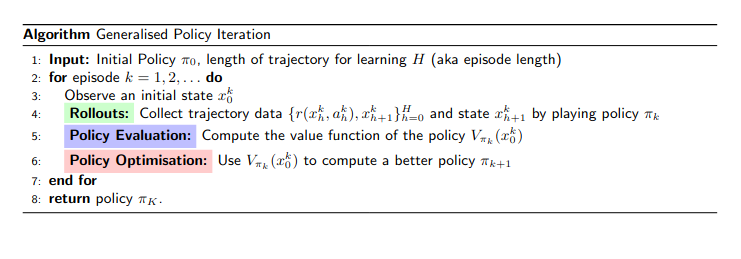

## Algorithm Comparison

<br>

| | **What is learned** | **Data usage** | **Exploration** |
|---|---|---|---|
| **DQN** | $Q(s,a)$ | Off-policy (replay buffer) | $\varepsilon$-greedy |
| **SAC** | $\pi(a|s)$ and $Q(s,a)$ | Off-policy (replay buffer) | Maximum entropy |
| **PPO** | $\pi(a|s)$ and $V(s)$ | On-policy (rollout, discard) | Stochastic policy + entropy bonus |

<br>

**Today's Progression:** off-policy value-based $\rightarrow$ off-policy actor-critic $\rightarrow$ on-policy actor-critic

## Setup

Installing dependencies and importing libraries.

In [ ]:
%pip install -q gymnasium torch numpy matplotlib tqdm

In [ ]:
import copy
import random
from abc import ABC, abstractmethod
from collections import deque

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Environment: CartPole-v1
A classic control task: **balance a pole on a cart** by applying left or right forces.
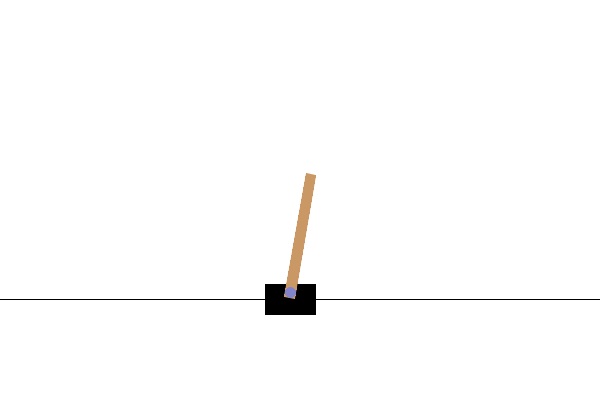


## CartPole Specification

<br>

| | |
|---|---|
| **State** | 4D continuous vector: cart position, cart velocity, pole angle, pole angular velocity |
| **Actions** | Discrete, {0, 1}: push left or push right |
| **Reward** | +1 per timestep the pole stays upright |
| **Termination** | Pole angle exceeds ±12°, cart leaves bounds, or 500 steps elapsed |
| **Solved** | Return of 500 |

## Gymnasium API

<br>

Gymnasium provides a **standard interface** for all environments.

In [ ]:
env = gym.make("CartPole-v1")        # create the environment

state, info = env.reset(seed=42)     # reset to initial state
print(f"Initial state:  {state}")
print(f"State shape:    {env.observation_space.shape}")
print(f"Action space:   {env.action_space}")   # Discrete(2): left or right

In [ ]:
# One step: send an action, receive (next_state, reward, terminated, truncated, info)
next_state, reward, terminated, truncated, info = env.step(action=1)

print(f"After step(1):")
print(f"  next_state:   {next_state}")
print(f"  reward:       {reward}")
print(f"  terminated:   {terminated}")

env.close()

## CartPole Dynamics

<br>

The `step()` method implements the complete environment dynamics:

1. Apply force based on action
2. Compute cart-pole equations of motion
3. Euler integration to update state
4. Check termination conditions
5. Return the standard 5-tuple

## CartPole Step Function

```python
def step(self, action):
    x, x_dot, theta, theta_dot = self.state
    force = self.force_mag if action == 1 else -self.force_mag
    costheta, sintheta = np.cos(theta), np.sin(theta)

    # Cart-pole equations of motion (Barto, Sutton & Anderson, 1983)
    temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
    thetaacc = (self.gravity * sintheta - costheta * temp) / (
        self.length * (4/3 - self.masspole * costheta**2 / self.total_mass)
    )
    xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

    # Euler integration
    x     = x     + self.tau * x_dot
    x_dot = x_dot + self.tau * xacc
    theta     = theta     + self.tau * theta_dot
    theta_dot = theta_dot + self.tau * thetaacc

    self.state = (x, x_dot, theta, theta_dot)

    # Episode ends if pole falls or cart leaves track
    terminated = bool(
        x < -self.x_threshold or x > self.x_threshold
        or theta < -self.theta_threshold_radians
        or theta > self.theta_threshold_radians
    )
    reward = 1.0  # +1 for every step, including the terminal step
    return np.array(self.state, dtype=np.float32), reward, terminated, False, {}
```

Each call to `step(action)` returns: `(observation, reward, terminated, truncated, info)`

## Poll: Random Policy Performance

<br>

A random policy selects actions uniformly at random.

<br>

**How many timesteps do you expect it to survive on average?**

<br>

- A) ~10 steps
- B) ~20-30 steps
- C) ~50-100 steps
- D) ~200+ steps

In [ ]:
# Random policy on CartPole - visualization
from matplotlib import animation
from IPython.display import HTML

env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset(seed=0)
frames = [env.render()]

for _ in range(50):
    action = env.action_space.sample()  # Random action
    state, _, terminated, truncated, _ = env.step(action)
    frames.append(env.render())
    if terminated or truncated:
        state, _ = env.reset(seed=0)

env.close()

In [ ]:
# Create animation
fig, ax = plt.subplots(figsize=(4, 3))
ax.axis("off")
img = ax.imshow(frames[0])

def update(f):
    img.set_data(f)
    return [img]

anim = animation.FuncAnimation(
    fig, update, frames=frames, interval=50, blit=True
)
plt.close(fig)
HTML(anim.to_jshtml())

## Poll Answer

In [ ]:
# Compute average episode length for a random policy
env = gym.make("CartPole-v1")
n_episodes = 100
episode_lengths = []

for i in range(n_episodes):
    state, _ = env.reset(seed=i)
    steps = 0
    done = False

    while not done:
        action = ...  # Random action
        state, reward, terminated, truncated, _ = ...  # Take a step in the environment
        steps += 1
        done = ... or ...  # Check if episode is done

    episode_lengths.append(steps)

env.close()

avg_steps = np.mean(episode_lengths)
std_steps = np.std(episode_lengths)
print(f"Random policy over {n_episodes} episodes:")
print(f"  Average steps: {avg_steps:.1f} ± {std_steps:.1f}")
print(f"  Min: {min(episode_lengths)}, Max: {max(episode_lengths)}")

## The Agent Interface

<br>

Every agent implements two methods, corresponding to the two phases of **Generalized Policy Iteration**:

<br>

$$\pi \xrightarrow{\text{evaluate}} Q^\pi \xrightarrow{\text{improve}} \pi'$$

## Agent Methods

<br>

**`act(state, explore)`**
- Select an action given current estimates
- With `explore=True`: add noise or sample stochastically
- With `explore=False`: act greedily

<br>

**`update(**kwargs)`**
- Update internal estimates from collected experience
- Updates Q-values, policy parameters, or both

In [ ]:
class Agent(ABC):
    """Base class for all RL agents."""

    @abstractmethod
    def act(self, state: np.ndarray, explore: bool = True):
        """Select an action given the current state."""
        ...

    @abstractmethod
    def update(self, **kwargs):
        """Update internal estimates from experience."""
        ...

## Evaluation

<br>

**During training:** the agent explores
- Takes random actions ($\varepsilon$-greedy in DQN)
- Samples from stochastic policy (SAC, PPO)
- Training returns are **noisy**

<br>

**Evaluation:** runs the learned policy **greedily**
- No exploration noise
- No randomness
- Averages returns over several episodes

In [ ]:
def evaluate(env_name: str, policy_fn, n_episodes: int = 10, seed: int = 0) -> float:
    """Evaluate a policy for n_episodes, return mean return."""
    env = gym.make(env_name)
    total_returns = []

    for i in range(n_episodes):
        state, _ = env.reset(seed=seed + i)
        ep_return = 0.0
        done = False

        while not done:
            action = ... # Get action from policy
            state, reward, terminated, truncated, _ = env.step(action)
            ep_return += ...  # Accumulate reward
            done = terminated or truncated

        total_returns.append(ep_return)

    env.close()
    return float(np.mean(total_returns))

## Fixing Random Seeds

<br>

Deep RL algorithms are **inherently stochastic**:

- Random weight initialization
- Environment resets
- Exploration noise
- Mini-batch sampling

<br>

Two runs of the same algorithm can yield **very different** learning curves.

## Reproducibility

<br>

We fix random seeds for **Python**, **NumPy**, and **PyTorch** before every experiment.

<br>

This ensures:
- Results are **deterministic** across runs
- Differences between algorithms reflect **genuine algorithmic differences**

<br>

When comparing algorithms, we train across **multiple seeds** to report mean performance with error bands.

In [ ]:
def set_seed(seed: int = 42) -> None:
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

## Plotting and Video Helpers

<br>

Utilities for:
- Visualizing training curves (with error bands across seeds)
- Recording short videos of trained agents

In [ ]:
def plot_returns(
    results: dict[str, list[list[float]]],
    window: int = 20,
    title: str = "Training Returns",
) -> None:
    """Plot smoothed training curves with error bands."""
    plt.figure(figsize=(8, 4))
    for label, runs in results.items():
        kernel = np.ones(window) / window
        smoothed = [np.convolve(r, kernel, mode="valid") for r in runs]
        min_len = min(len(s) for s in smoothed)
        smoothed = np.array([s[:min_len] for s in smoothed])
        mean = smoothed.mean(axis=0)
        std = smoothed.std(axis=0)
        x = np.arange(min_len)
        plt.plot(x, mean, label=label)
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def record_video(env_name: str, policy_fn, max_steps: int = 500, seed: int = 0):
    """Record a single episode and return an HTML5 video."""
    from matplotlib import animation
    from IPython.display import HTML

    env = gym.make(env_name, render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    frames = [env.render()]
    done = False
    step = 0

    while not done and step < max_steps:
        action = policy_fn(state)
        state, _, terminated, truncated, _ = env.step(action)
        frames.append(env.render())
        done = terminated or truncated
        step += 1
    env.close()

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.axis("off")
    img = ax.imshow(frames[0])
    def update(f):
        img.set_data(f)
        return [img]
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())

# DQN: Deep Q-Network

<br>

Mnih et al., 2015

## DQN: Core Idea

<br>

**DQN** approximates the Q-function with a neural network $Q(s,a;\theta)$

<br>

Replaces the lookup table of tabular Q-learning.

<br>

Each update is framed as **regression**:
- Given $(s, a)$ and target $r + \gamma \max_{a'} Q(s', a')$
- Minimize squared error

## Two Stabilization Mechanisms

<br>

### 1. Replay Buffer

- Stores transitions
- Samples random mini-batches
- Breaks temporal correlation
- Enables data reuse

### 2. Target Network

The regression target depends on the parameters being updated:

$$r + \gamma \max_{a'} Q(s', a'; \theta)$$

This creates a **moving target**.

<br>

A separate network $\theta^-$, updated slowly, provides **stable targets**.

## DQN Loss Function

<br>

The loss minimizes mean-squared TD error:

<br>

$$L(\theta) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{B}} \left[ \left( r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta) \right)^2 \right]$$

<br>

where $\mathcal{B}$ is the replay buffer.

## DQN in GPI Terms

<br>

### Evaluation
Minimizing TD error to improve $Q$

<br>

### Improvement
Acting $\varepsilon$-greedy with respect to $Q$

## Replay Buffer Implementation

<br>

Fixed-size FIFO buffer storing $(s, a, r, s', \text{done})$ transitions.

In [ ]:
class ReplayBuffer:
    """Fixed-size FIFO buffer storing (s, a, r, s', done) transitions."""

    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self) -> int:
        return len(self.buffer)

    def sample(self, batch_size: int):
        """Sample a random mini-batch of transitions."""
        batch = ... # Sample a random batch from the buffer
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors
        actions_arr = np.array(actions)
        if actions_arr.dtype in (np.float32, np.float64):
            actions_t = torch.FloatTensor(actions_arr).to(device)
        else:
            actions_t = torch.LongTensor(actions_arr).to(device)

        return (
            torch.FloatTensor(np.array(states)).to(device),
            actions_t,
            torch.FloatTensor(rewards).to(device),
            torch.FloatTensor(np.array(next_states)).to(device),
            torch.FloatTensor(dones).to(device),
        )

## MLP Helper Function

<br>

A simple utility to build fully-connected networks with ReLU activations.

In [ ]:
def mlp(
    input_dim: int,
    output_dim: int,
    hidden_dims: list[int] = [128, 128],
    output_activation: type[nn.Module] | None = None,
) -> nn.Sequential:
    """Build a simple MLP with ReLU hidden activations."""
    layers: list[nn.Module] = []
    prev_dim = input_dim
    for h in hidden_dims:
        layers += [nn.Linear(prev_dim, h), nn.ReLU()]
        prev_dim = h
    layers.append(nn.Linear(prev_dim, output_dim))
    if output_activation is not None:
        layers.append(output_activation())
    return nn.Sequential(*layers)

## Poll: The Max Operator Problem

<br>

The TD target uses $\max_{a'} Q(s', a'; \theta^-)$ to estimate the value of the next state.

<br>

Both **action selection** and **action evaluation** use the same network.

<br>

**What problem might this cause?**

- A) The target changes too slowly
- B) Systematic overestimation of Q-values
- C) The agent explores too much
- D) Gradients become unstable

## Double DQN

<br>

Van Hasselt et al., 2016

<br>

**Problem:** The $\max$ operator both selects and evaluates the best action using the same network.

<br>

When Q-values are noisy:
- The network picks whichever action has the **highest noise**
- Then evaluates it with that same **inflated estimate**
- Causes **[Answer of the poll]**

**Decouple selection from evaluation:**

- Online network **selects** the action
- Target network **evaluates** it

<br>

$$y = r + \gamma\, Q(s', \arg\max_{a'} Q(s', a'; \theta); \theta^-)$$

## Epsilon Schedule

<br>

The exploration rate $\varepsilon$ decays linearly over $N_{\text{decay}}$ steps:

$$\varepsilon_t = \max\left(\varepsilon_{\text{end}}, \varepsilon_{\text{start}} - \frac{t}{N_{\text{decay}}} (\varepsilon_{\text{start}} - \varepsilon_{\text{end}})\right)$$

<br>

Shifts from **exploration** to **exploitation** as Q-values improve.

Importantly $\varepsilon_{\text{end}}$ should not be $0$ otherwise the training will get stuck and no chance to converge toward the optimal policy.

## Hard Target Update

<br>

Every $K$ steps, copy the online network weights to the target network:

<br>

$$\theta^- \leftarrow \theta$$

<br>

This provides stable targets for regression.

## DQN Agent: Initialization

In [ ]:
class DQNAgent(Agent):
    def __init__(
        self,
        state_dim: int, # Dimension of the state space (e.g., 4 for CartPole-v1)
        action_dim: int, # Dimension of the action space (e.g., 2 for CartPole-v1)
        lr: float = 1e-3, # Learning rate for the Adam optimizer
        gamma: float = 0.99, # Discount factor for future rewards
        buffer_size: int = 10_000, # Maximum capacity of the replay buffer
        batch_size: int = 64, # Size of the mini-batch sampled from the replay buffer
        target_update_freq: int = 200, # Frequency (in steps) to update the target network
        epsilon_start: float = 1.0, # Initial exploration rate
        epsilon_end: float = 0.01, # Minimum exploration rate
        epsilon_decay_steps: int = 5000, # Number of steps over which epsilon decays
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq

        # Online Q-network and target Q-network
        self.q_net = mlp(state_dim, action_dim).to(device)
        self.target_net = mlp(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)

        # Epsilon schedule
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.step_count = 0

    # GPI Improvement step: epsilon greedy action selection
    @torch.no_grad()
    def act(self, state: np.ndarray, explore: bool = True) -> int:
        """Epsilon-greedy action selection."""
        # With probability epsilon, take random action
        if explore and random.random() < self.epsilon:
            return ... # Random action

        # Otherwise, take greedy action
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        return int(...) # Get action with highest Q-value from the online network

    # GPI Evaluation stept: Q-function update via TD learning
    def update(self, **kwargs) -> float | None:
        """One gradient step on the Double-DQN loss."""
        if len(self.buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        # Q(s, a) for the actions actually taken
        q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Double DQN target: select with online net, evaluate with target net
        with torch.no_grad():
            best_actions = self.q_net(next_states).argmax(dim=1, keepdim=True)
            next_q = self.target_net(next_states).gather(1, best_actions).squeeze(1)
            targets = ... # Compute TD targets

        loss = F.mse_loss(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon and update target network
        self.epsilon = ... # Decay epsilon
        self.step_count += 1
        if self.step_count % self.target_update_freq == 0:
            ... # Update target network

        return loss.item()

## Off-Policy Training

<br>

DQN is **off-policy**:

- Stores every transition $(s, a, r, s', \text{done})$ in a replay buffer
- Learns by sampling random mini-batches
- Independent of which policy version generated them

<br>

This **decouples data collection from learning**.

## Why Use a Replay Buffer?

<br>

### Problem 1: Temporal Correlation

- Consecutive states are nearly identical
- Training on correlated samples destabilizes gradient descent
- SGD assumes i.i.d. data

<br>

**Solution:** Random sampling from a large buffer restores the i.i.d. assumption.

### Problem 2: Catastrophic Forgetting

- Without replay, the agent only trains on states from its **current region**
- Overwrites what it learned before

<br>

**Solution:** A buffer retains old transitions, letting the agent revisit diverse states.

## Sample Efficiency

<br>

The agent learns from a mix of recent and older experience.

<br>

Off-policy methods are **sample-efficient**: every transition can be reused many times.

## The Off-Policy Loop

<br>

$$\text{act} \;\to\; \text{step env} \;\to\; \text{store } (s,a,r,s') \;\to\; \text{sample batch} \;\to\; \text{update networks}$$

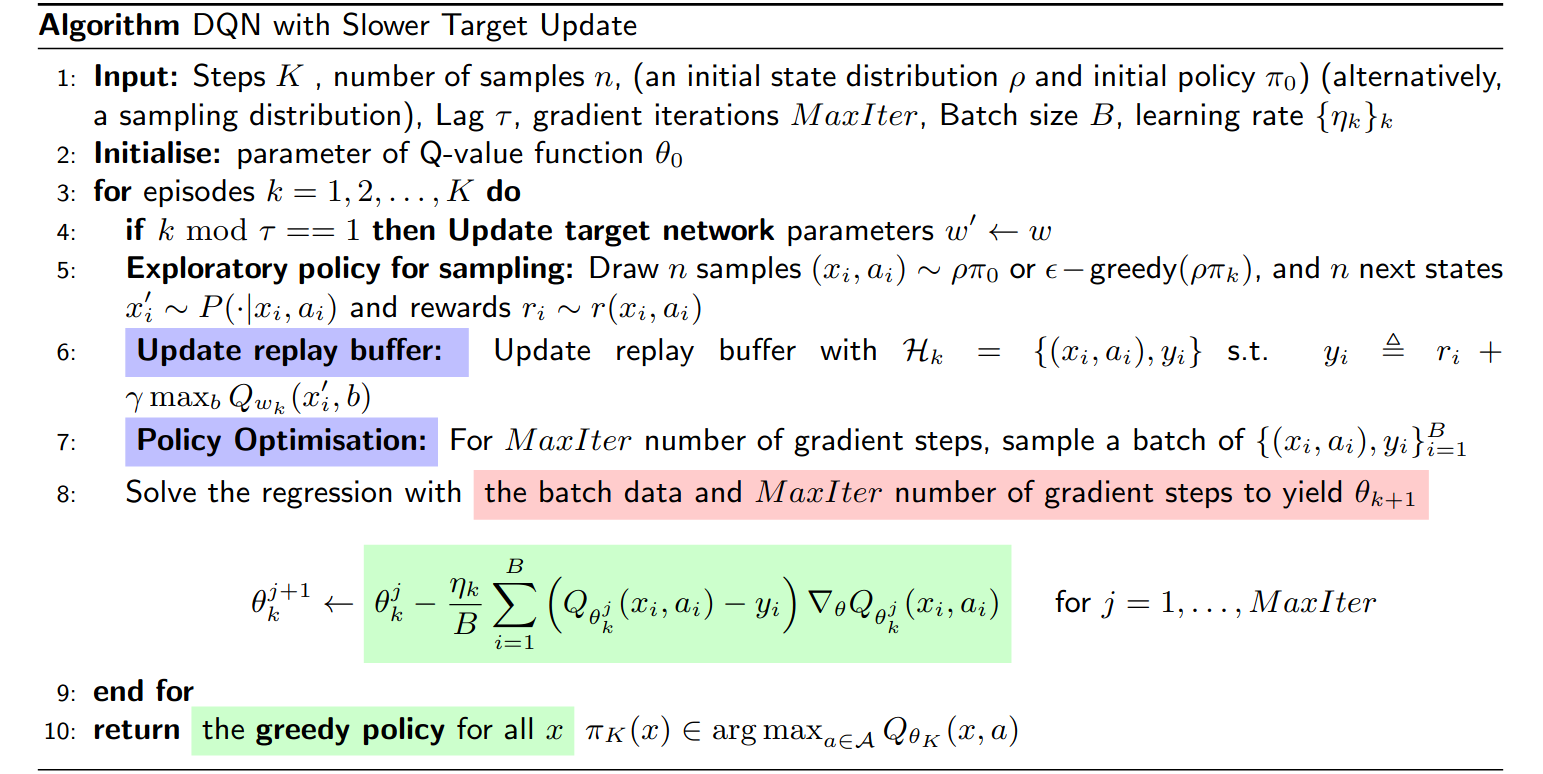

In [ ]:
def train_off_policy(
    agent: Agent,
    env_name: str,
    n_episodes: int = 300,
    seed: int = 42,
    eval_every: int = 20,
    desc: str = "Training",
    store_action=None,
) -> list[float]:
    """Shared off-policy training loop for DQN and SAC."""
    env = gym.make(env_name)
    episode_returns: list[float] = []

    pbar = trange(n_episodes, desc=desc)
    for ep in pbar:
        state, _ = env.reset(seed=seed + ep)
        ep_return = 0.0
        done = False

        # === EPISODE LOOP ===
        # Each iteration: act -> step -> store -> sample -> update
        while not done:
            # 1. ACT: Select action using current policy (with exploration)
            action = ... # Get action from policy

            # 2. STEP: Execute action in environment
            next_state, reward, terminated, truncated, _ = ... # Take a step in the environment
            done = terminated or truncated

            # 3. STORE: Save transition to replay buffer
            if store_action is not None:
                store_action(agent, state, action, reward, next_state, done)
            else:
                agent.buffer.push(state, action, reward, next_state, float(done))

            # 4. UPDATE: Sample a random batch and perform gradient step
            ... # Update agent from experience
            state = next_state
            ep_return += reward

        episode_returns.append(ep_return)

        # Evaluate periodically
        if ep % eval_every == 0:
            eval_score = ... # Evaluate current policy without exploration
            # Below code updates the progress bas
            postfix = {"ret": f"{ep_return:.0f}", "eval": f"{eval_score:.0f}"}
            if hasattr(agent, "epsilon"):
                postfix["eps"] = f"{agent.epsilon:.2f}"
            pbar.set_postfix(**postfix)

    env.close()
    return episode_returns

## Training DQN

<br>

Training runs for **500 episodes** across **3 seeds**.

<br>

The plots show smoothed returns with standard deviation bands.

In [ ]:
SEEDS = [1, 2, 3]
dqn_runs = []

for s in SEEDS:
    set_seed(s)
    env = gym.make("CartPole-v1")
    agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)
    env.close()
    dqn_runs.append(
        train_off_policy(agent, "CartPole-v1", n_episodes=500, seed=s, desc=f"DQN seed={s}")
    )

dqn_agent = agent  # keep last for video

In [ ]:
plot_returns({"DQN": dqn_runs}, title="DQN on CartPole-v1")

## DQN: Trained Agent

<br>

Watching the trained policy in action.

In [ ]:
record_video("CartPole-v1", lambda s: dqn_agent.act(s, explore=False))

## DQN Summary

<br>

| Component | Description |
|---|---|
| **What is learned** | Q-function $Q(s,a;\theta)$ |
| **Policy** | Implicit ($\varepsilon$-greedy w.r.t. $Q$) |
| **Data usage** | Off-policy (replay buffer) |
| **Stabilization** | Target network + replay buffer |
| **Improvement** | Double DQN decouples selection/evaluation |

## Takeaways

<br>

1. **Function approximation** enables generalization across states

2. **Replay buffer** breaks correlation and enables data reuse

3. **Target network** stabilizes learning by providing fixed regression targets

4. **Double DQN** addresses overestimation by decoupling action selection from evaluation

# SAC: Soft Actor-Critic

[Haarnoja et al., 2018]

<br>

DQN derives its policy **implicitly**: act greedily with respect to $Q$, plus $\varepsilon$-random exploration.

<br>

SAC learns an **explicit stochastic policy** $\pi(a|s)$ alongside the Q-function.

---

## Poll: $\varepsilon$-greedy Limitations

<br>


$\varepsilon$-greedy exploration chooses a random action with probability $\varepsilon$.

<br>

**What are its limitations?**

<br>

- A) Random actions ignore which unexplored actions might be promising
- B) $\varepsilon$ must be tuned manually
- C) Exploration is undirected, with no preference for uncertain regions
- D) All of the above
---



## Poll Answer

<br>

**[Answer]**

<br>

$\varepsilon$-greedy picks random actions **uniformly**. It cannot direct exploration towards promising or uncertain regions. The schedule for $\varepsilon$ must be tuned by hand, and the noise is completely independent of the learned Q-values.

<br>

SAC addresses this: exploration emerges from the **entropy bonus** in the objective, so the policy itself learns *where* and *how much* to explore.

## From DDPG to SAC

<br>

**DDPG** (Lillicrap et al., 2016) is an off-policy actor-critic for continuous control.

<br>

SAC starts from the same foundation and fixes three key weaknesses:

<br>

| DDPG weakness | SAC solution |
|---|---|
| **Deterministic policy** $\Rightarrow$ brittle exploration (requires OU noise) | **Stochastic policy** with entropy bonus $\Rightarrow$ principled, self-tuning exploration |
| **Single Q-network** $\Rightarrow$ overestimation | **Twin Q-networks** with $\min(Q_1, Q_2)$ $\Rightarrow$ pessimistic value estimate |
| **Manual noise schedule** $\Rightarrow$ sensitive hyperparameter | **Automatic temperature** $\alpha$ $\Rightarrow$ adapts exploration over training |

## SAC: Core Idea

<br>

The distinguishing feature of SAC is **entropy regularization**.

<br>

The objective includes policy entropy $\mathcal{H}(\pi)$, which measures how spread out the action distribution is:

<br>

$$J(\pi) = \mathbb{E}_{\pi} \left[ \sum_t \gamma^t \left( r_t + \alpha\, \mathcal{H}\big(\pi(\cdot|s_t)\big) \right) \right]$$

<br>

- Higher $\alpha$ favors entropy (**exploration**)
- Lower $\alpha$ favors return (**exploitation**)

<br>

Among policies with similar returns, SAC prefers the one with **higher entropy**, acting as a regularizer against premature convergence.

## Shared Foundations with DDPG

<br>

SAC **keeps** several DDPG ingredients:

<br>

- **Off-policy** learning with a **replay buffer**
- **Polyak-averaged target networks**: $\theta^- \leftarrow \tau\theta + (1-\tau)\theta^-$
- **Actor-critic** architecture: separate policy and Q-function networks
- **Reparameterization trick** for backpropagating through stochastic sampling

<br>

The key addition is the **maximum entropy** framework that turns exploration from an external heuristic into part of the objective itself.

## What Changes from DDPG

<br>

### Policy

- DDPG: deterministic $a = \mu_\theta(s)$, exploration via additive noise $a + \epsilon$
- SAC: stochastic $a \sim \pi_\theta(\cdot|s)$, exploration **built into the objective**

<br>

### Q-Target

- DDPG: $\;y = r + \gamma\, Q(s', \mu(s'))$
- SAC: $\;y = r + \gamma\left(Q(s', a') - \alpha \log \pi(a'|s')\right), \quad a' \sim \pi(\cdot|s')$

<br>

### Overestimation

- DDPG: single Q-network (prone to overestimation, like DQN)
- SAC: twin Q-networks, use $\min(Q_1, Q_2)$ (pessimistic, like TD3)

## SAC Architecture

<br>

### Twin Q-Networks ($Q_1, Q_2$)

- Taking $\min(Q_1, Q_2)$ in the target counteracts **overestimation**
- Addresses the same problem as Double DQN through pessimistic evaluation

<br>

### Polyak-Averaged Targets

- $\theta^- \leftarrow \tau\theta + (1-\tau)\theta^-$ at every step
- Smoother updates than DQN's periodic hard copy

<br>

### Automatic Temperature Tuning

- $\alpha$ is adjusted via gradient descent to maintain a target entropy level
- Removes a sensitive hyperparameter

## SAC Algorithm

<br>

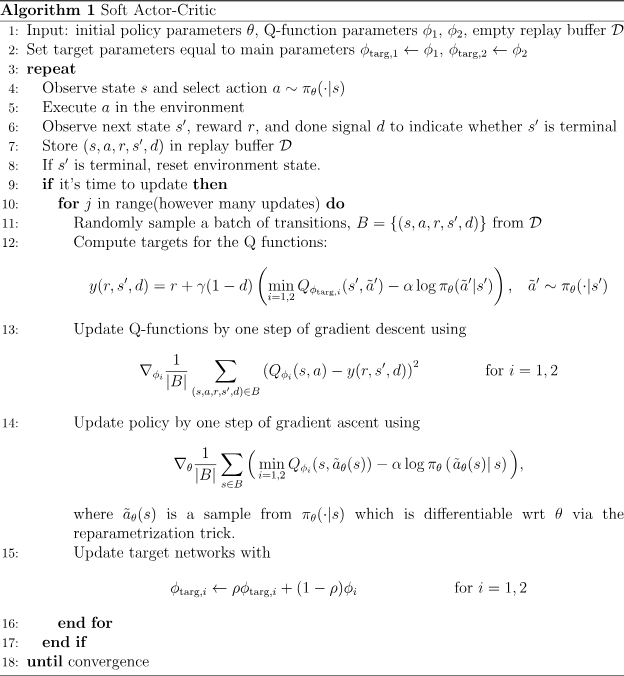

## Discrete SAC

<br>

For discrete actions, the policy outputs a **categorical distribution**.

<br>

Entropy has a closed form: $\mathcal{H}(\pi) = -\sum_a \pi(a|s) \log \pi(a|s)$

## Soft Bellman Target

<br>

The Q-target includes entropy of the next-state policy:

<br>

$$y = r + \gamma (1-d)\, \sum_{a'} \pi(a'|s')\left[\min_{j=1,2} Q_j(s',a') - \alpha \log \pi(a'|s')\right]$$

<br>

The $(1-d)$ factor masks the bootstrap term: when the episode is done ($d=1$), the target reduces to $y = r$.

<br>

## Policy Loss

<br>

Increase probability of high-Q actions while maintaining entropy:

<br>

$$L_\pi = \mathbb{E}_s\left[\sum_a \pi(a|s)\left(\alpha \log \pi(a|s) - \min_{j=1,2} Q_j(s,a)\right)\right]$$

## Temperature Loss

<br>

The temperature $\alpha$ controls the entropy-reward trade-off:
- Large $\alpha$ encourages **exploration** (high entropy)
- Small $\alpha$ favors **exploitation**

<br>

Rather than tuning $\alpha$ by hand, SAC learns it automatically:

<br>

$$L_\alpha = \alpha\left(\mathcal{H}(\pi) - \bar{\mathcal{H}}\right)$$

<br>

- When entropy drops below target $\bar{\mathcal{H}}$ $\Rightarrow$ $\alpha$ **increases** (explore more)
- When entropy exceeds target $\Rightarrow$ $\alpha$ **decreases** (exploit more)

<br>

The target $\bar{\mathcal{H}}$ is typically set to $-\log(1/|A|)$ for discrete actions.

## Softmax Activation

<br>

For the discrete SAC version, we use a **Softmax activation** to select actions.

In [ ]:
class SoftmaxOutput(nn.Module):
    """Softmax along the last dimension (for use as output activation)."""
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.softmax(x, dim=-1)

## Polyak Averaging (Soft Target Update)

<br>

SAC updates target networks at **every step** with a small interpolation rate $\tau$, instead of DQN's periodic hard copy.

In [ ]:
@torch.no_grad()
def soft_update(target: nn.Module, source: nn.Module, tau: float) -> None:
    """Polyak-average target towards source: target <- tau*source + (1-tau)*target."""
    for tp, sp in zip(target.parameters(), source.parameters()):
        tp.data.copy_(tau * sp.data + (1 - tau) * tp.data)

In [ ]:
class DiscreteSACAgent(Agent):

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        lr: float = 3e-4,
        gamma: float = 0.99,
        tau: float = 0.005,
        buffer_size: int = 10_000,
        batch_size: int = 64,
        target_entropy_ratio: float = 0.5,
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Twin Q-networks: state -> Q-value for each action
        self.q1, self.q1_target = self._make_twin(mlp(state_dim, action_dim))
        self.q2, self.q2_target = self._make_twin(mlp(state_dim, action_dim))

        # Stochastic policy: state -> probability distribution over actions
        self.policy = mlp(state_dim, action_dim, output_activation=SoftmaxOutput).to(device)

        # Entropy tuning: target = fraction of max entropy, optimize in log-space
        self.target_entropy = -np.log(1.0 / action_dim) * target_entropy_ratio
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)

        self.q_optimizer = torch.optim.Adam(
            list(self.q1.parameters()) + list(self.q2.parameters()), lr=lr
        )
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr)

        self.buffer = ReplayBuffer(buffer_size)

    @staticmethod
    def _make_twin(net: nn.Module) -> tuple[nn.Module, nn.Module]:
        net = net.to(device)
        return net, copy.deepcopy(net)

    @property
    def alpha(self) -> torch.Tensor:
        return self.log_alpha.exp()

    @torch.no_grad()
    def act(self, state: np.ndarray, explore: bool = True) -> int:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy(state_t)
        if explore:
            return ... # Sample action from the probability distribution
        return int(probs.argmax(dim=1).item())

    def update(self, **kwargs) -> dict[str, float] | None:
        if len(self.buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        # -- Q update --
        with torch.no_grad():
            next_probs = self.policy(next_states)
            next_log_probs = torch.log(next_probs + 1e-8)
            next_q1 = self.q1_target(next_states)
            next_q2 = self.q2_target(next_states)
            min_next_q = torch.min(next_q1, next_q2)
            # V(s') = sum_a pi(a|s') [min_Q(s',a) - alpha * log pi(a|s')]
            soft_v = ... # Compute soft value of next states under current policy
            target_q = rewards + self.gamma * (1 - dones) * soft_v

        q1_pred = self.q1(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        q2_pred = self.q2(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        q_loss = F.mse_loss(q1_pred, target_q) + F.mse_loss(q2_pred, target_q)

        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # -- Policy update: maximize Q while keeping entropy high --
        probs = self.policy(states)
        log_probs = torch.log(probs + 1e-8)
        with torch.no_grad():
            min_q = ... # Get min_Q(s,a) for all actions under current policy
        policy_loss = ... # Compute policy loss that encourages high Q and high entropy

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # -- Temperature update: push entropy towards target --
        with torch.no_grad():
            probs_detached = self.policy(states)
            log_probs_detached = torch.log(probs_detached + 1e-8)
            entropy = -(probs_detached * log_probs_detached).sum(dim=1).mean()
        alpha_loss = self.log_alpha * (entropy - self.target_entropy)

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # -- Soft target update --
        soft_update(self.q1_target, self.q1, self.tau)
        soft_update(self.q2_target, self.q2, self.tau)

        return {"q_loss": q_loss.item(), "pi_loss": policy_loss.item(), "alpha": self.alpha.item()}

### Training

SAC is off-policy and reuses the same `train_off_policy()` loop as DQN.

Training runs for 500 episodes for comparison with DQN.

In [ ]:
SEEDS = [1, 2, 3]
sac_runs = []
for s in SEEDS:
    set_seed(s)
    env = gym.make("CartPole-v1")
    agent = DiscreteSACAgent(
        state_dim=env.observation_space.shape[0], action_dim=env.action_space.n
    )
    env.close()
    sac_runs.append(train_off_policy(agent, "CartPole-v1", n_episodes=500, seed=s, desc=f"SAC (Discrete) seed={s}"))
discrete_sac_agent = agent  # keep last for video

plot_returns(
    {"DQN": dqn_runs, "SAC (Discrete)": sac_runs},
    title="CartPole-v1: DQN vs SAC",
)

In [ ]:
record_video("CartPole-v1", lambda s: discrete_sac_agent.act(s, explore=False))

# PPO: Proximal Policy Optimization
PPO (Schulman et al., 2017) is **on-policy**: it collects a batch of experience under the current policy, updates, then discards the data.



## PPO: Proximal Policy Optimization

---

**Poll: Why discard data?**

Off-policy methods (DQN, SAC) store and reuse past transitions. On-policy methods discard data after each update. Why might discarding data be desirable?

- A) Reduces memory usage
- B) Avoids distribution mismatch between old and current policy
- C) Simpler implementation
- D) Faster wall-clock training

---



## Motivation:

[Answer to the poll]

## Estimating Advantages
- PPO estimates advantages $A(s,a) = Q(s,a) - V(s)$ using a learned value function $V_\phi(s)$ as baseline. The advantage indicates whether an action performed better or worse than expected.
- Positive advantages increase the action's probability, whereas negative advantages decrease it.

**Generalized Advantage Estimation.** GAE (Schulman et al., 2016) computes advantages by interpolating between bias and variance through parameter $\lambda$:

$$\hat{A}_t = \sum_{l=0}^{T-t} (\gamma\lambda)^l \delta_{t+l}, \quad \text{where } \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$$

- $\lambda = 0$: One-step TD advantage ($\hat{A}_t = \delta_t$). Low variance, high bias (depends on $V$ accuracy).
- $\lambda = 1$: Monte Carlo advantage. Low bias, high variance.
- $\lambda = 0.95$: Standard setting that balances the two.

## Trust Region & Clipped Surrogate Objective

- In policy gradient methods, a small parameter change can cause a large behavior change. This mismatch between parameter space and policy space makes unconstrained updates unstable.

- PPO constrains updates in **policy space** directly. The importance ratio $\rho_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{\text{old}}}(a_t|s_t)}$ measures how much the policy has changed. PPO clips this ratio to $[1-\varepsilon, 1+\varepsilon]$:

$$L^{\text{clip}}(\theta) = \mathbb{E}_t \left[ \min\left( \rho_t(\theta)\, \hat{A}_t,\; \text{clip}(\rho_t(\theta), 1-\varepsilon, 1+\varepsilon)\, \hat{A}_t \right) \right]$$
![image.jpg](https://www.researchgate.net/publication/362943674/figure/fig1/AS:11431281081010679@1661483926467/sualization-of-the-trust-region-method-algorithm-The-parameter-vector-x-is-iteratively_W640.jpg)

- This allows **multiple gradient steps on the same batch**: without clipping, a single step would shift the policy enough to make the data stale.

- The full loss combines three terms:

$$L = L^{\text{clip}} + c_v \cdot L^{\text{value}} - c_e \cdot \mathcal{H}(\pi)$$


![image.svg](https://spinningup.openai.com/en/latest/_images/math/e62a8971472597f4b014c2da064f636ffe365ba3.svg)

### On-Policy Data Collection

- PPO uses a `RolloutBuffer` instead of a `ReplayBuffer`. A replay buffer grows over time and samples uniformly from all past experience. A rollout buffer fills once per rollout, supports a few epochs of mini-batch updates, then clears.

- The training loop collects fixed-length rollouts (2048 steps), runs multiple update epochs, then discards the data. This structure differs enough from off-policy training that PPO requires its own loop rather than reusing `train_off_policy()`.

In [ ]:
class RolloutBuffer:
    """On-policy storage for PPO rollouts."""

    def __init__(self):
        self.states: list[np.ndarray] = []
        self.actions: list = [] # Changed type hint to be more general
        self.log_probs: list[float] = []
        self.rewards: list[float] = []
        self.dones: list[float] = []
        self.values: list[float] = []

    """Push the rollout data into the rollout buffer"""
    def push(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(float(done))
        self.values.append(value)

    """ Generalized Advantage Estimation (GAE) """
    def compute_gae(
        self, last_value: float, gamma: float = 0.99, lam: float = 0.95
    ) -> tuple[torch.Tensor, torch.Tensor]:
        values = self.values + [last_value]  # bootstrap from V(s_T)
        advantages = []
        gae = 0.0
        for t in reversed(range(len(self.rewards))):
            delta = ...  # one-step TD error
            gae = ...  # recursive GAE
            advantages.insert(0, gae)
        advantages = torch.FloatTensor(advantages).to(device)
        returns = advantages + torch.FloatTensor(self.values).to(device)  # A = R - V, so R = A + V
        return advantages, returns

    """Get minibatches of fixed length for improvement steps"""
    def get_batches(
        self,
        advantages: torch.Tensor,
        returns: torch.Tensor,
        batch_size: int,
    ):
        states = torch.FloatTensor(np.array(self.states)).to(device)

        # Dynamically determine action tensor type based on stored data
        actions_arr = np.array(self.actions)
        if actions_arr.dtype in (np.float32, np.float64):
            actions_t = torch.FloatTensor(actions_arr).to(device)
        else:
            actions_t = torch.LongTensor(actions_arr).to(device)

        old_log_probs = torch.FloatTensor(self.log_probs).to(device)
        n = len(self.states)
        indices = np.random.permutation(n)
        for start in range(0, n, batch_size):
            idx = indices[start : start + batch_size]
            yield states[idx], actions_t[idx], old_log_probs[idx], advantages[idx], returns[idx]

    def clear(self):
        self.__init__()

In [ ]:
class PPOAgent(Agent):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        lr: float = 3e-4,            # Learning rate (shared for policy and value nets)
        gamma: float = 0.99,         # Discount factor
        lam: float = 0.95,           # GAE lambda: controls bias-variance trade-off
        clip_eps: float = 0.2,       # PPO clipping range for the surrogate objective
        k_epochs: int = 4,           # Number of optimization epochs per rollout
        batch_size: int = 64,        # Mini-batch size within each epoch
        entropy_coef: float = 0.01,  # Weight of entropy bonus (encourages exploration)
        value_coef: float = 0.5,     # Weight of value loss in the combined objective
        max_grad_norm: float = 0.5,  # Gradient clipping for stability
    ):
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.k_epochs = k_epochs
        self.batch_size = batch_size
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm

        # Separate networks for policy (softmax output) and value (scalar output)
        self.policy_net = mlp(state_dim, action_dim, output_activation=SoftmaxOutput).to(device)
        self.value_net = mlp(state_dim, 1).to(device)
        # Single optimizer for both networks (common in PPO implementations)
        self.optimizer = torch.optim.Adam(
            list(self.policy_net.parameters()) + list(self.value_net.parameters()), lr=lr
        )
        self.buffer = RolloutBuffer()  #Initialize rollout buffer

    # -- GPI: Improve (action selection) --
    def act(self, state: np.ndarray, explore: bool = True) -> tuple[int, float, float]:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        probs = self.policy_net(state_t)
        if explore:
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            # Return action, log_prob (needed for importance ratio), and value estimate
            return action.item(), dist.log_prob(action).item(), self.value_net(state_t).item()
        return int(probs.argmax(dim=1).item()), 0.0, self.value_net(state_t).item()

    @torch.no_grad()
    def get_value(self, state: np.ndarray) -> float:
        """Bootstrap value for the last state in a rollout (used in GAE computation)."""
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        return self.value_net(state_t).item()

    # -- GPI: Evaluate (policy gradient + value update) --
    def update(self, **kwargs) -> None:
        last_value = kwargs["last_value"]

        # Compute GAE advantages and discounted returns from the completed rollout
        advantages, returns = self.buffer.compute_gae(last_value, self.gamma, self.lam)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)  # normalize for stable gradients

        # Multiple passes over the same rollout data (sample efficiency vs. staleness)
        for _ in range(self.k_epochs):
            for states, actions, old_log_probs, advs, rets in self.buffer.get_batches(
                advantages, returns, self.batch_size
            ):
                probs = self.policy_net(states)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(actions)
                entropy = ... # Compute mean entropy of the current policy over the batch

                # Importance sampling ratio: pi_new(a|s) / pi_old(a|s)
                ratio = (new_log_probs - old_log_probs).exp()

                # Clipped surrogate objective: prevent too-large policy updates
                surr1 = ... # Unclipped objective: ratio * advantage
                surr2 = ... # Clipped objective: clip ratio to [1 - clip_eps, 1 + clip_eps] * advantage
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(self.value_net(states).squeeze(), rets)

                # Combined loss: policy + value - entropy bonus
                loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(
                    list(self.policy_net.parameters()) + list(self.value_net.parameters()),
                    self.max_grad_norm,
                )
                self.optimizer.step()

        self.buffer.clear() #Clear out all the rollout data

### Training

Unlike `train_off_policy()` used by DQN and SAC, PPO's training loop is structured around **fixed-length rollouts** rather than individual transitions:

- **No replay buffer.** Instead of storing transitions and resampling old data, PPO collects a fresh rollout of 2048 steps, learns from it in multiple mini-batch passes, then discards it entirely.
- **Step-based rather than episode-based.** The loop counts total environment steps, not episodes. A rollout may span multiple episode boundaries; episodes that end mid-rollout are simply reset and collection continues.
- **Bootstrapped value at rollout end.** Since a rollout rarely ends exactly at an episode boundary, the agent estimates the value of the final state to complete the GAE computation -- this avoids discarding partial trajectories.
- **Multiple epochs per rollout.** Each collected batch is reused for `k_epochs` passes of gradient updates, squeezing more learning from each rollout while the clipping mechanism prevents the policy from drifting too far.

In [ ]:
def train_ppo(
    env_name: str = "CartPole-v1",
    total_steps: int = 100_000,
    rollout_length: int = 2048,
    seed: int = 1,
    eval_every: int = 5,
) -> tuple[PPOAgent, list[float]]:
    set_seed(seed)
    env = gym.make(env_name)
    agent = PPOAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.n,
    )
    episode_returns: list[float] = []
    state, _ = env.reset(seed=seed)
    ep_return = 0.0
    ep_count = 0
    n_updates = total_steps // rollout_length

    pbar = trange(n_updates, desc=f"PPO seed={seed}")
    for update_i in pbar:
        # Collect a fixed-length rollout
        for _ in range(rollout_length):
            action, log_prob, value = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.buffer.push(state, action, log_prob, reward, done, value)
            state = next_state
            ep_return += reward

            if done:
                episode_returns.append(ep_return)
                ep_return = 0.0
                ep_count += 1
                state, _ = env.reset(seed=seed + ep_count)

        # Bootstrap value for the incomplete trajectory at the end of the rollout
        last_value = ...
        agent.update(last_value=last_value)

        #Evaluation
        if update_i % eval_every == 0:
            eval_score = ... # Evaluate current policy without exploration
            pbar.set_postfix(
                episodes=len(episode_returns),
                last_ret=f"{episode_returns[-1]:.0f}" if episode_returns else "--",
                eval=f"{eval_score:.0f}",
            )

    env.close()
    return agent, episode_returns


SEEDS = [1, 2, 3]
ppo_runs = []
for s in SEEDS:
    agent, returns = train_ppo(seed=s)
    ppo_runs.append(returns)
ppo_agent = agent

plot_returns(
    {"DQN": dqn_runs, "SAC (Discrete)": sac_runs, "PPO": ppo_runs},
    title="CartPole-v1: DQN vs SAC vs PPO",
)

In [ ]:
len(ppo_runs[0])

In [ ]:
record_video("CartPole-v1", lambda s: ppo_agent.act(s, explore=False)[0])

## Comparison

The algorithms differ along several axes:

**Sample efficiency.** DQN and SAC reuse transitions via replay, making them more sample-efficient than PPO, which discards data after each update.

**Stability.** PPO's clipped objective provides stable updates by construction. DQN can be sensitive to the epsilon schedule and target update frequency. SAC's automatic temperature tuning provides stability without manual intervention.

**Exploration.** DQN uses undirected $\varepsilon$-greedy exploration. PPO explores through its stochastic policy and an entropy bonus. SAC's maximum-entropy formulation provides the most principled exploration.

**Computational cost.** PPO requires one forward pass per environment step. DQN adds mini-batch updates from replay. SAC is most expensive per step (twin Q-networks, policy network, temperature updates).

Despite these differences, all three instantiate GPI:

| | **Evaluate** | **Improve** |
|---|---|---|
| **DQN** | Minimize TD error on $Q$ | $\varepsilon$-greedy w.r.t. $Q$ |
| **SAC** | Minimize soft TD error on $Q_1, Q_2$ | Maximize $Q - \alpha \log \pi$ |
| **PPO** | Compute GAE advantages from $V$ | Clipped policy gradient |

The two design axes are: *what to learn* (values, policy, or both) and *how to collect data* (on-policy vs. off-policy).

In [ ]:
plot_returns(
    {"DQN": dqn_runs, "SAC (Discrete)": sac_runs, "PPO": ppo_runs},
    title="CartPole-v1: DQN vs SAC vs PPO",
)

### Expected Results

On CartPole-v1:

- All three algorithms converge to the maximum return of 500.
- DQN and SAC (off-policy) typically converge faster in episodes due to data reuse.
- PPO may show more variance early, but the clipped objective provides steady improvement.
- SAC's entropy-driven exploration tends to produce the smoothest learning curves.

---

**Poll: Algorithm selection**

You need to train a robot arm. Real-world samples are expensive (slow, causes wear on hardware). Simulation is available but imperfect. Which algorithm would you prioritize investigating first?

- A) DQN: simple, well-understood
- B) SAC: sample-efficient, handles continuous actions naturally
- C) PPO: stable, widely used in robotics
- D) Depends on factors not mentioned here

---

## Continuous Action Spaces

So far, every algorithm operated on **discrete** actions (push left or push right in CartPole). Many real-world problems -- robotics, continuous control, autonomous driving -- require **continuous** actions: torques, velocities, or steering angles drawn from a continuous range.

### Environment: Pendulum-v1

Pendulum-v1 is a classic control benchmark: apply a torque $a \in [-2, 2]$ to swing up and balance an inverted pendulum.

| | |
|---|---|
| **State** | $(\cos\theta,\; \sin\theta,\; \dot\theta)$ -- angle and angular velocity |
| **Action** | Torque $a \in [-2, 2]$ (continuous, 1-dimensional) |
| **Reward** | $-(\theta^2 + 0.1\,\dot\theta^2 + 0.001\,a^2)$ -- penalizes angle error, velocity, and effort |
| **Termination** | None (fixed 200-step episodes) |
| **Good performance** | Return $> -200$ |

Unlike CartPole, the action space is continuous, so we cannot enumerate actions. This rules out DQN (which requires $\max_a Q(s,a)$ over a finite set) and motivates policy-based approaches that output continuous distributions.

## Continuous SAC

<br>

SAC extends to **continuous action spaces**, where actions cannot be enumerated.

## Gaussian Policy with Reparameterization

<br>

The network outputs mean $\mu(s)$ and log standard deviation $\log \sigma(s)$.

<br>

To sample:
1. Draw $\epsilon \sim \mathcal{N}(0, I)$
2. Compute $u = \mu + \sigma \cdot \epsilon$

<br>

The **reparameterization trick** (Kingma & Welling, 2014) makes sampling differentiable with respect to $\mu$ and $\sigma$.

## Tanh Squashing

<br>

Most environments expect **bounded actions**.

<br>

Applying $a = \tanh(u)$ maps the unbounded Gaussian sample to $[-1, 1]$.

<br>

This change of variables requires a log-probability correction:

<br>

$$\log \pi(a|s) = \log p(u|s) - \sum_i \log(1 - \tanh^2(u_i))$$

<br>

**Q-networks** take the concatenation $(s, a)$ as input and output a scalar.

In [ ]:
class GaussianPolicy(nn.Module):
    """Gaussian policy with tanh squashing for continuous SAC."""

    LOG_STD_MIN = -20
    LOG_STD_MAX = 2

    def __init__(self, state_dim: int, action_dim: int, hidden_dims: list[int] = [128, 128]):
        super().__init__()
        layers: list[nn.Module] = []
        prev_dim = state_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev_dim, h), nn.ReLU()]
            prev_dim = h
        self.backbone = nn.Sequential(*layers)
        self.mu_head = nn.Linear(prev_dim, action_dim)
        self.log_std_head = nn.Linear(prev_dim, action_dim)

    def forward(self, state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = self.backbone(state)
        mu = self.mu_head(x)
        log_std = self.log_std_head(x).clamp(self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = log_std.exp()

        # Reparameterized sample: u = μ + σ·ε, then squash through tanh
        normal = torch.distributions.Normal(mu, std)
        u = normal.rsample()
        action = torch.tanh(u)

        # Log-prob with tanh correction
        log_prob = normal.log_prob(u) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1)

        return action, log_prob

    def deterministic(self, state: torch.Tensor) -> torch.Tensor:
        x = self.backbone(state)
        return torch.tanh(self.mu_head(x))

## ContinuousSACAgent

<br>

Mirrors the discrete variant with two changes:

<br>

- **Q-networks** take concatenated $(s, a)$ inputs
- **Policy** is the `GaussianPolicy` defined above

<br>

The `store_action` callback divides raw environment actions by `action_scale` before storing, so the buffer always contains actions in $[-1, 1]$ matching the tanh output range.

In [ ]:
class ContinuousSACAgent(Agent):
    """Same structure as discrete SAC, but Q-networks take (s, a) as input
    and the policy is a tanh-squashed Gaussian."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        action_scale: float = 2.0,
        lr: float = 3e-4,
        gamma: float = 0.99,
        tau: float = 0.005,
        buffer_size: int = 50_000,
        batch_size: int = 256,
    ):
        self.action_dim = action_dim
        self.action_scale = action_scale
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Q(s, a) -> scalar (takes concatenated input, like DDPG)
        self.q1, self.q1_target = self._make_twin(mlp(state_dim + action_dim, 1))
        self.q2, self.q2_target = self._make_twin(mlp(state_dim + action_dim, 1))

        self.policy = GaussianPolicy(state_dim, action_dim).to(device)

        # Target entropy heuristic: -dim(A)
        self.target_entropy = -action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)

        self.q_optimizer = torch.optim.Adam(
            list(self.q1.parameters()) + list(self.q2.parameters()), lr=lr
        )
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr)

        self.buffer = ReplayBuffer(buffer_size)

    @staticmethod
    def _make_twin(net: nn.Module) -> tuple[nn.Module, nn.Module]:
        net = net.to(device)
        return net, copy.deepcopy(net)

    @property
    def alpha(self) -> torch.Tensor:
        return self.log_alpha.exp()

    @torch.no_grad()
    def act(self, state: np.ndarray, explore: bool = True) -> np.ndarray:
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        if explore:
            action, _ = self.policy(state_t)
        else:
            action = self.policy.deterministic(state_t)
        return action.squeeze(0).cpu().numpy() * self.action_scale

    def update(self, **kwargs) -> dict[str, float] | None:
        if len(self.buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        if actions.dim() == 1:
            actions = actions.unsqueeze(1)

        # -- Q update (soft Bellman target with clipped double-Q) --
        with torch.no_grad():
            next_actions, next_log_probs = self.policy(next_states)
            next_sa = torch.cat([next_states, next_actions], dim=1)
            next_q1 = self.q1_target(next_sa).squeeze(1)
            next_q2 = self.q2_target(next_sa).squeeze(1)
            next_q = torch.min(next_q1, next_q2) - self.alpha * next_log_probs
            target_q = rewards + self.gamma * (1 - dones) * next_q

        sa = torch.cat([states, actions], dim=1)
        q1_pred = self.q1(sa).squeeze(1)
        q2_pred = self.q2(sa).squeeze(1)
        q_loss = F.mse_loss(q1_pred, target_q) + F.mse_loss(q2_pred, target_q)

        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # -- Policy update --
        new_actions, log_probs = self.policy(states)
        sa_new = torch.cat([states, new_actions], dim=1)
        q1_val = self.q1(sa_new).squeeze(1)
        q2_val = self.q2(sa_new).squeeze(1)
        min_q = torch.min(q1_val, q2_val)
        policy_loss = (self.alpha.detach() * log_probs - min_q).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # -- Temperature update --
        alpha_loss = -(self.log_alpha * (log_probs.detach() + self.target_entropy)).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # -- Soft target update --
        soft_update(self.q1_target, self.q1, self.tau)
        soft_update(self.q2_target, self.q2, self.tau)

        return {"q_loss": q_loss.item(), "pi_loss": policy_loss.item(), "alpha": self.alpha.item()}

In [ ]:
def _norm_action(agent, state, action, reward, next_state, done):
    agent.buffer.push(state, action / agent.action_scale, reward, next_state, float(done))


SEEDS = [1, 2, 3]
cont_sac_runs = []
for s in SEEDS:
    set_seed(s)
    env = gym.make("Pendulum-v1")
    agent = ContinuousSACAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.shape[0],
        action_scale=float(env.action_space.high[0]),
    )
    env.close()
    cont_sac_runs.append(train_off_policy(
        agent, "Pendulum-v1", n_episodes=300, seed=s,
        desc=f"SAC (Continuous) seed={s}", store_action=_norm_action,
    ))
cont_sac_agent = agent  # keep last for video

plot_returns({"Continuous SAC": cont_sac_runs}, title="Continuous SAC on Pendulum-v1", window=10)

In [ ]:
record_video("Pendulum-v1", lambda s: cont_sac_agent.act(s, explore=False))

### Continuous PPO

- PPO also handles continuous actions. Instead of a categorical distribution, the policy outputs the parameters of a Gaussian: mean $\mu(s)$ and standard deviation $\sigma(s)$. Actions are sampled from $\mathcal{N}(\mu, \sigma^2)$ during training; at evaluation time, we use $\mu$ directly.

- The `train_ppo` function below is adapted for continuous environments: the policy network outputs a Gaussian instead of a softmax, and we no longer need a `SoftmaxOutput` layer.

In [ ]:
class ContinuousPPOAgent(Agent):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        action_scale: float = 2.0,
        lr: float = 3e-4,
        gamma: float = 0.99,
        lam: float = 0.95,
        clip_eps: float = 0.2,
        k_epochs: int = 4,
        batch_size: int = 64,
        entropy_coef: float = 0.01,
        value_coef: float = 0.5,
        max_grad_norm: float = 0.5,
    ):
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.k_epochs = k_epochs
        self.batch_size = batch_size
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        self.action_scale = action_scale

        # Policy: MLP outputting mean and log_std of a Gaussian
        hidden = [128, 128]
        layers = []
        prev = state_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        self.backbone = nn.Sequential(*layers).to(device)
        self.mu_head = nn.Linear(prev, action_dim).to(device)
        self.log_std = nn.Parameter(torch.zeros(action_dim, device=device))

        self.value_net = mlp(state_dim, 1).to(device)
        self.optimizer = torch.optim.Adam(
            list(self.backbone.parameters()) + [self.log_std]
            + list(self.mu_head.parameters()) + list(self.value_net.parameters()),
            lr=lr,
        )
        self.buffer = RolloutBuffer()

    def _dist(self, state_t):
        x = self.backbone(state_t)
        mu = self.mu_head(x)
        std = self.log_std.exp().expand_as(mu)
        return torch.distributions.Normal(mu, std)

    def act(self, state, explore=True):
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist = self._dist(state_t)
        if explore:
            action = dist.sample() # Sample an action from Gaussian while exploring
            log_prob = dist.log_prob(action).sum(-1).item()
        else:
            action = dist.mean # Use Gaussian mean while exploit
            log_prob = 0.0
        value = self.value_net(state_t).item()
        return action.squeeze(0).cpu().detach().numpy() * self.action_scale, log_prob, value

    @torch.no_grad()
    def get_value(self, state):
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        return self.value_net(state_t).item()

    def update(self, **kwargs):
        last_value = kwargs["last_value"]
        advantages, returns = self.buffer.compute_gae(last_value, self.gamma, self.lam)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.k_epochs):
            for states, actions, old_log_probs, advs, rets in self.buffer.get_batches(
                advantages, returns, self.batch_size
            ):
                # Rescale stored actions back to policy space
                actions_policy = actions / self.action_scale
                dist = self._dist(states)
                new_log_probs = dist.log_prob(actions_policy).sum(-1)
                entropy = dist.entropy().sum(-1).mean()

                ratio = (new_log_probs - old_log_probs).exp()
                surr1 = ratio * advs
                surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * advs
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(self.value_net(states).squeeze(), rets)
                loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(
                    list(self.backbone.parameters()) + [self.log_std]
                    + list(self.mu_head.parameters()) + list(self.value_net.parameters()),
                    self.max_grad_norm,
                )
                self.optimizer.step()

        self.buffer.clear()

In [ ]:
def train_ppo_continuous(
    env_name: str = "Pendulum-v1",
    total_steps: int = 200_000,
    rollout_length: int = 2048,
    seed: int = 1,
    eval_every: int = 5,
) -> tuple[ContinuousPPOAgent, list[float]]:
    set_seed(seed)
    env = gym.make(env_name)
    agent = ContinuousPPOAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.shape[0],
        action_scale=float(env.action_space.high[0]),
    )
    episode_returns: list[float] = []
    state, _ = env.reset(seed=seed)
    ep_return = 0.0
    ep_count = 0
    n_updates = total_steps // rollout_length

    pbar = trange(n_updates, desc=f"PPO (Cont.) seed={seed}")
    for update_i in pbar:
        for _ in range(rollout_length):
            action, log_prob, value = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.buffer.push(state, action, log_prob, reward, done, value)
            state = next_state
            ep_return += reward

            if done:
                episode_returns.append(ep_return)
                ep_return = 0.0
                ep_count += 1
                state, _ = env.reset(seed=seed + ep_count)

        last_value = agent.get_value(state)
        agent.update(last_value=last_value)

        if update_i % eval_every == 0:
            eval_score = evaluate(
                env_name, lambda s: agent.act(s, explore=False)[0]
            )
            pbar.set_postfix(
                episodes=len(episode_returns),
                last_ret=f"{episode_returns[-1]:.0f}" if episode_returns else "--",
                eval=f"{eval_score:.0f}",
            )

    env.close()
    return agent, episode_returns


SEEDS = [1, 2, 3]
cont_ppo_runs = []
for s in SEEDS:
    agent, returns = train_ppo_continuous(seed=s)
    cont_ppo_runs.append(returns)
cont_ppo_agent = agent

plot_returns({"PPO (Continuous)": cont_ppo_runs}, title="Continuous PPO on Pendulum-v1", window=10)

In [ ]:
record_video("Pendulum-v1", lambda s: cont_ppo_agent.act(s, explore=False)[0])

### Continuous Control: SAC vs PPO

Both SAC and PPO can handle continuous actions, but their trade-offs become clearer on Pendulum:

- **SAC** learns a stochastic policy with entropy regularization and reuses data via replay. This makes it sample-efficient on continuous tasks.
- **PPO** collects fresh rollouts and discards them after each update. It needs more environment steps but provides stable, predictable learning.

The comparison plot below shows how they perform on the same environment.

In [ ]:
plot_returns(
    {"SAC (Continuous)": cont_sac_runs, "PPO (Continuous)": cont_ppo_runs},
    title="Pendulum-v1: SAC vs PPO",
    window=10,
)